In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch, torch.nn as nn
import torch.nn.functional as F

import data_cleaning
import feature_align
from data_cleaning import clean_cust_df, clean_event_df, clean_product_xlsx
from feature_align import align_product_features

cust_df = data_cleaning.clean_cust_df('../cust_dataset.csv')
event_df = data_cleaning.clean_event_df('../event_dataset.csv')
product_df = data_cleaning.clean_product_xlsx('../productLabels_multiSpreadsheets.xlsx')

# 对齐不同类别的产品特征
aligned_dict = align_product_features(product_df, min_numeric_cols=4)
for category, data in aligned_dict.items():
    df = data['df']  # 该类别的产品DataFrame
    numeric_cols = data['numeric_cols']  # 该类别可用的数值列
    print(f"类别 {category}: {len(numeric_cols)} 个数值特征")

[CLEAN] cust_df cleaned: (1108827, 5), columns=['cust_no', 'gender', 'age', 'edu_bg', 'marriage_situ_cd']
[CLEAN] event_df cleaned: (338939, 11), columns=['cust_no', 'prod_id', 'event_id', 'event_type', 'event_level', 'event_date', 'event_term', 'event_rate', 'event_amt', 'A', 'B']
[CLEAN] product_df cleaned: (270, 19), columns=['prod_id', 'interval_level', 'deposit_type1', 'deposit_type2', '__sheet__', 'credit_level', 'credit_amt_cd', 'credit_type1', 'credit_type2', 'new_flag', 'frtn_type', 'fr_period_type', 'fr_prod_attr', 'fr_prod_type', 'fr_risk_level', 'channel_type', 'channel_type2', 'pay_type1', 'pay_type2']
类别 D: 16 个数值特征
类别 C: 16 个数值特征
类别 A: 16 个数值特征
类别 N: 16 个数值特征
类别 P: 16 个数值特征


In [5]:
merged_df = pd.merge(event_df, cust_df, on='cust_no', how='left')
merged_df = pd.merge(merged_df, product_df, on='prod_id', how='left')
merged_df.fillna(0, inplace=True)
merged_df = merged_df.drop(['cust_no','event_type','A','B','__sheet__'],axis=1)

cols_to_convert = merged_df.columns.difference(['prod_id'])
merged_df[cols_to_convert] = merged_df[cols_to_convert].astype('float32')
print(merged_df.shape)
print(merged_df.dtypes)

(338939, 28)
prod_id              object
event_id            float32
event_level         float32
event_date          float32
event_term          float32
event_rate          float32
event_amt           float32
gender              float32
age                 float32
edu_bg              float32
marriage_situ_cd    float32
interval_level      float32
deposit_type1       float32
deposit_type2       float32
credit_level        float32
credit_amt_cd       float32
credit_type1        float32
credit_type2        float32
new_flag            float32
frtn_type           float32
fr_period_type      float32
fr_prod_attr        float32
fr_prod_type        float32
fr_risk_level       float32
channel_type        float32
channel_type2       float32
pay_type1           float32
pay_type2           float32
dtype: object


In [6]:
merged_df.head()

,prod_id,event_id,event_level,event_date,event_term,event_rate,event_amt,gender,age,edu_bg,...,new_flag,frtn_type,fr_period_type,fr_prod_attr,fr_prod_type,fr_risk_level,channel_type,channel_type2,pay_type1,pay_type2
0,C0001,0.0,0.0,0.0,60.0,0.0,0.0,0.0,47.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C0001,0.0,0.0,0.0,60.0,0.0,0.0,1.0,31.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C0001,0.0,0.0,0.0,60.0,0.0,0.0,1.0,59.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C0001,0.0,0.0,0.0,60.0,0.0,0.0,0.0,37.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C0001,0.0,0.0,0.0,60.0,0.0,0.0,0.0,36.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# prod_id 映射
unique_prods = merged_df['prod_id'].astype(str).unique().tolist()
PAD, OOV = 0, 1
id2idx = {p: i+2 for i,p in enumerate(unique_prods)}  # 0=PAD,1=OOV 预留
num_items = len(id2idx) + 2

def prod_to_idx(pid: str) -> int:
    return id2idx.get(str(pid), OOV)

# embed_dim = 64
# prod_emb = nn.Embedding(num_embeddings=num_items, embedding_dim=embed_dim, padding_idx=PAD)
# batch_prod_ids = ['C0001','C0002','UNKNOWN']  # 举例
# idx_tensor = torch.tensor([prod_to_idx(x) for x in batch_prod_ids], dtype=torch.long)
# emb_tensor = prod_emb(idx_tensor)  # [batch, embed_dim]

In [8]:
# ============= 数据准备 =============
# 分离特征和标签
def prepare_data(df):
    # 获取特征列（除了prod_id）
    feature_cols = [col for col in df.columns if col != 'prod_id']
    X = df[feature_cols].values.astype(np.float32)
    
    # 将prod_id转换为索引
    y = df['prod_id'].astype(str).apply(prod_to_idx).values
    
    return X, y

X, y = prepare_data(merged_df)
print(f"特征形状: {X.shape}")
print(f"标签形状: {y.shape}")
print(f"标签类别数: {num_items}")
print(f"特征维度: {X.shape[1]}")


特征形状: (338939, 27)
标签形状: (338939,)
标签类别数: 261
特征维度: 27


In [9]:
# ============= 划分训练集和测试集 =============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None  # 注意：数据量大可能无法分层
)

print(f"训练集大小: {len(X_train)}")
print(f"测试集大小: {len(X_test)}")

# 创建Dataset
class Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 创建DataLoader
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoader创建完成:")
print(f"训练批次数: {len(train_loader)}")
print(f"测试批次数: {len(test_loader)}")

训练集大小: 271151
测试集大小: 67788

DataLoader创建完成:
训练批次数: 2119
测试批次数: 530


In [ ]:
# ============= 定义Factorization Machine (FM)组件 =============
class FM(nn.Module):
    """Factorization Machine - 捕捉特征间的二阶交互"""
    def __init__(self, num_features, k):
        super().__init__()
        self.linear = nn.Linear(num_features, 1)  # 线性部分
        self.V = nn.Parameter(torch.randn(num_features, k))  # 隐向量矩阵
        # 初始化
        nn.init.normal_(self.V, mean=0, std=0.01)
        
    def forward(self, x):
        # x shape: [batch, num_features]
        # 线性部分
        linear_part = self.linear(x)  # [batch, 1]
        
        # 交互部分: 使用优化的FM公式
        # sum((x*V)^2 - (x^2)*(V^2)) / 2
        inter_1 = torch.pow(torch.mm(x, self.V), 2)  # [batch, k]
        inter_2 = torch.mm(torch.pow(x, 2), torch.pow(self.V, 2))  # [batch, k]
        interaction_part = 0.5 * torch.sum(inter_1 - inter_2, dim=1, keepdim=True)  # [batch, 1]
        
        return linear_part + interaction_part


# ============= 定义融合Transformer和FM的模型 =============
class ProductTransformerFM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=2, dropout=0.2, num_heads=4, fm_k=16, fusion='concat'):
        """
        Args:
            input_dim: 输入特征维度 (27)
            hidden_dim: Transformer隐藏维度
            num_classes: 输出类别数
            num_layers: Transformer层数
            dropout: Dropout率
            num_heads: 注意力头数
            fm_k: FM隐向量维度
            fusion: 融合方式 ('concat' 或 'add')
        """
        super(ProductTransformerFM, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.fusion = fusion
        
        # ========== Transformer部分 ==========
        # 位置编码
        self.pos_embedding = nn.Parameter(torch.randn(1, input_dim, hidden_dim))
        # 输入投影层
        self.input_proj = nn.Linear(1, hidden_dim)
        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        # Transformer Encoder层
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # ========== FM部分 ==========
        self.fm = FM(num_features=input_dim, k=fm_k)
        
        # ========== 融合层 ==========
        if fusion == 'concat':
            # 将Transformer输出和FM输出concat
            # Transformer: [batch, hidden_dim]
            # FM: [batch, 1] -> 扩展到 [batch, hidden_dim] 或直接concat
            fusion_dim = hidden_dim + 1  # FM输出是标量
            self.fusion_proj = nn.Linear(fusion_dim, hidden_dim)
        else:  # fusion == 'add'
            # FM输出投影到hidden_dim后相加
            self.fm_proj = nn.Linear(1, hidden_dim)
            fusion_dim = hidden_dim
        
        # ========== 输出层 ==========
        self.fc1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim * 2, num_classes)
        
        # 初始化权重
        self._init_weights()
        
    def _init_weights(self):
        """初始化模型权重"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        # x shape: [batch, input_dim] (例如: [128, 27])
        batch_size = x.size(0)
        
        # ========== Transformer路径 ==========
        # Reshape成序列: [batch, seq_len, 1]
        x_reshaped = x.unsqueeze(2)  # [batch, 27, 1]
        # 输入投影
        x_proj = self.input_proj(x_reshaped)  # [batch, 27, hidden_dim]
        # 添加位置编码
        x_proj = x_proj + self.pos_embedding  # [batch, 27, hidden_dim]
        # 添加CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [batch, 1, hidden_dim]
        x_proj = torch.cat([cls_tokens, x_proj], dim=1)  # [batch, 28, hidden_dim]
        # Transformer编码
        x_transformed = self.transformer(x_proj)  # [batch, 28, hidden_dim]
        # 使用CLS token的输出作为序列表示
        transformer_output = x_transformed[:, 0, :]  # [batch, hidden_dim]
        
        # ========== FM路径 ==========
        fm_output = self.fm(x)  # [batch, 1]
        
        # ========== 融合两部分 ==========
        if self.fusion == 'concat':
            # 将FM输出和Transformer输出concat
            fused = torch.cat([transformer_output, fm_output], dim=1)  # [batch, hidden_dim + 1]
            fused = self.fusion_proj(fused)  # [batch, hidden_dim]
        else:  # fusion == 'add'
            # 将FM输出投影到hidden_dim后相加
            fm_proj = self.fm_proj(fm_output)  # [batch, hidden_dim]
            fused = transformer_output + fm_proj  # [batch, hidden_dim]
        
        # ========== 输出层 ==========
        out = self.fc1(fused)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# ============= 保留原Transformer模型（向后兼容） =============
class ProductTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=2, dropout=0.2, num_heads=4):
        super(ProductTransformer, self).__init__()
        
        self.input_dim = input_dim  # 27
        self.hidden_dim = hidden_dim
        self.seq_length = input_dim
        # 位置编码
        self.pos_embedding = nn.Parameter(torch.randn(1, input_dim, hidden_dim))
        # 输入投影层：将特征维度投影到hidden_dim
        self.input_proj = nn.Linear(1, hidden_dim)
        # 添加CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        # Transformer Encoder层
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # 全连接层用于输出
        self.fc1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim * 2, num_classes)
        # 初始化权重
        self._init_weights()
        
    def _init_weights(self):
        """初始化模型权重"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        # x shape: [batch, input_dim] (例如: [128, 27])
        batch_size = x.size(0)
        # Reshape成序列: [batch, seq_len, 1]
        x_reshaped = x.unsqueeze(2)  # [batch, 27, 1]
        # 输入投影
        x_proj = self.input_proj(x_reshaped)  # [batch, 27, hidden_dim]
        # 添加位置编码
        x_proj = x_proj + self.pos_embedding  # [batch, 27, hidden_dim]
        # 添加CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [batch, 1, hidden_dim]
        x_proj = torch.cat([cls_tokens, x_proj], dim=1)  # [batch, 28, hidden_dim]
        # Transformer编码
        x_transformed = self.transformer(x_proj)  # [batch, 28, hidden_dim]
        # 使用CLS token的输出（第一个token）作为序列表示
        cls_output = x_transformed[:, 0, :]  # [batch, hidden_dim]
        # 全连接层
        out = self.fc1(cls_output)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# 创建融合模型（Transformer + FM）
input_dim = X.shape[1]  # 27
hidden_dim = 128
num_layers = 2
num_heads = 4  # Transformer注意力头数
fm_k = 16  # FM隐向量维度
fusion_mode = 'concat'  # 融合方式: 'concat' 或 'add'

# 使用融合模型 ProductTransformerFM
model = ProductTransformerFM(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_classes=num_items,
    num_layers=num_layers,
    dropout=0.2,
    num_heads=num_heads,
    fm_k=fm_k,
    fusion=fusion_mode
)

# 打印模型信息
print(f"模型架构 (Transformer + FM):")
print(f"融合方式: {fusion_mode}")
print(f"FM隐向量维度: {fm_k}")
print(model)
print(f"\n模型参数数量: {sum(p.numel() for p in model.parameters()):,}")

# 测试前向传播
sample_x = torch.randn(2, input_dim)
sample_out = model(sample_x)
print(f"\n输入形状: {sample_x.shape}")
print(f"输出形状: {sample_out.shape}")
print(f"输出示例: {sample_out[0, :5]}")

# 测试FM组件单独输出
print(f"\n测试FM组件:")
with torch.no_grad():
    fm_only = model.fm(sample_x)
    print(f"FM输出形状: {fm_only.shape}")
    print(f"FM输出示例: {fm_only[0]}")


模型架构 (Transformer + FM):
融合方式: concat
FM隐向量维度: 16
ProductTransformerFM(
  (input_proj): Linear(in_features=1, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fm): FM(
    (linear): Linear(in_features=27, out_features=1, bias=True)
  )
  (fusion_proj): Linear(in_features=129, out_features=128, bias=True)
  

In [18]:
# ============= 训练设置 =============
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

model = model.to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# 训练参数
num_epochs = 5
print_every = 100  # 每N个batch打印一次

# 训练历史
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


使用设备: cpu


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
# ============= 训练循环 =============
print("开始训练...")

for epoch in range(num_epochs):
    # 训练模式
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # 前向传播
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # 反向传播
        loss.backward()
        
        # 梯度裁剪（防止梯度爆炸）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # 统计
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()
        
        # 打印进度
        if (batch_idx + 1) % print_every == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}, Acc: {100*train_correct/train_total:.2f}%')
    
    # 计算平均指标
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    
    # 验证
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()
    
    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    # 学习率调度
    scheduler.step(avg_val_loss)
    
    print(f'\nEpoch [{epoch+1}/{num_epochs}] 完成:')
    print(f'训练 - Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.2f}%')
    print(f'验证 - Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.2f}%')
    print('-' * 60)
    
print("\n训练完成!")


开始训练...
Epoch [1/5], Batch [100/2119], Loss: 0.4985, Acc: 92.05%
Epoch [1/5], Batch [200/2119], Loss: 0.2101, Acc: 92.40%
Epoch [1/5], Batch [300/2119], Loss: 0.2020, Acc: 92.49%
Epoch [1/5], Batch [400/2119], Loss: 0.4158, Acc: 92.24%
Epoch [1/5], Batch [500/2119], Loss: 0.3987, Acc: 92.38%
Epoch [1/5], Batch [600/2119], Loss: 0.0883, Acc: 92.42%
Epoch [1/5], Batch [700/2119], Loss: 0.2399, Acc: 92.38%
Epoch [1/5], Batch [800/2119], Loss: 0.0740, Acc: 92.43%
Epoch [1/5], Batch [900/2119], Loss: 0.6594, Acc: 92.28%
Epoch [1/5], Batch [1000/2119], Loss: 0.0567, Acc: 92.25%
Epoch [1/5], Batch [1100/2119], Loss: 0.1296, Acc: 92.36%
Epoch [1/5], Batch [1200/2119], Loss: 0.5061, Acc: 92.36%
Epoch [1/5], Batch [1300/2119], Loss: 0.2308, Acc: 92.43%
Epoch [1/5], Batch [1400/2119], Loss: 0.2456, Acc: 92.47%
Epoch [1/5], Batch [1500/2119], Loss: 0.2120, Acc: 92.51%
Epoch [1/5], Batch [1600/2119], Loss: 0.0809, Acc: 92.46%
Epoch [1/5], Batch [1700/2119], Loss: 0.2197, Acc: 92.45%
Epoch [1/5], Ba

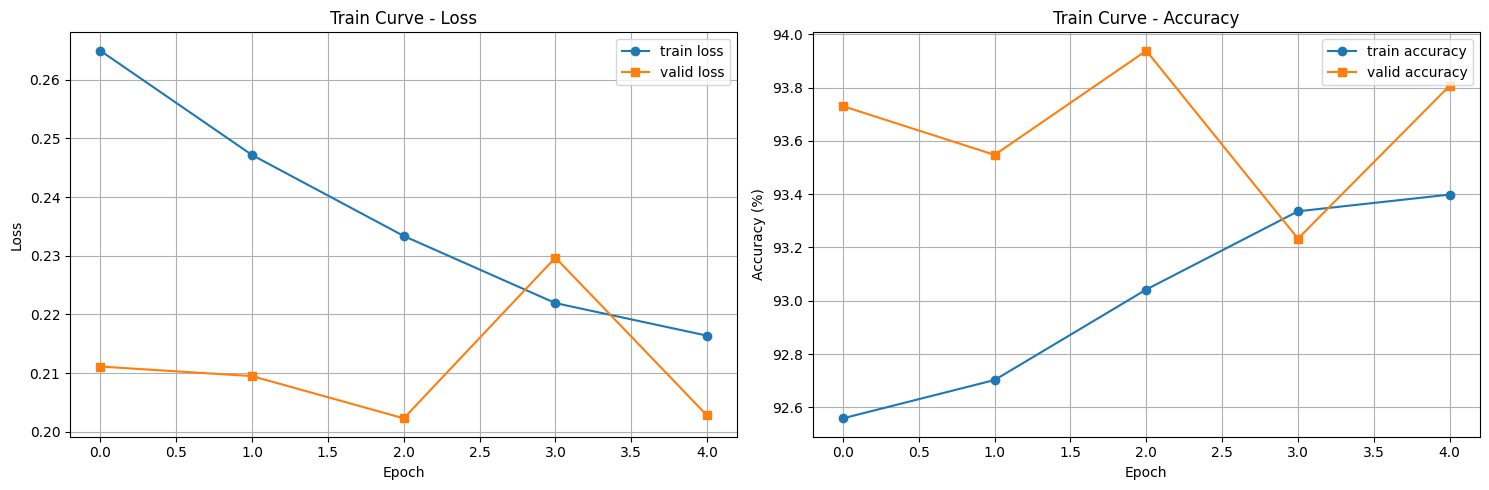


最终结果:
最佳训练准确率: 93.40%
最佳验证准确率: 93.94%


In [20]:
# ============= 可视化训练曲线 =============
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train loss', marker='o')
plt.plot(val_losses, label='valid loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Curve - Loss')
plt.legend()
plt.grid(True)

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train accuracy', marker='o')
plt.plot(val_accuracies, label='valid accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train Curve - Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n最终结果:")
print(f"最佳训练准确率: {max(train_accuracies):.2f}%")
print(f"最佳验证准确率: {max(val_accuracies):.2f}%")

In [14]:
# ============= 保存模型 =============
import os

# 创建models目录
os.makedirs('models', exist_ok=True)

# 保存完整模型
model_path = 'models/transformer_fm_product_classifier.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': model,
    'id2idx': id2idx,
    'num_items': num_items,
    'input_dim': input_dim,
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'num_heads': num_heads,
    'fm_k': fm_k,  # FM隐向量维度
    'fusion': fusion_mode,  # 融合方式
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
}, model_path)

print(f"模型已保存到: {model_path}")

# 创建反向映射（idx -> prod_id）
idx2prod = {v: k for k, v in id2idx.items()}
print(f"\n反向映射创建完成 共 {len(idx2prod)} 个产品")


模型已保存到: models/transformer_fm_product_classifier.pth

反向映射创建完成 共 259 个产品


In [15]:
# ============= 测试预测功能 =============
# 预测函数
def predict_prod_id(model, features, top_k=5):
    """
    预测产品ID
    Args:
        model: 训练好的模型
        features: 特征向量 [batch, features]
        top_k: 返回top-k预测结果
    Returns:
        top_k_preds: 预测的产品ID列表
        top_k_probs: 对应的概率
    """
    model.eval()
    with torch.no_grad():
        features = torch.FloatTensor(features).to(device)
        outputs = model(features)
        probs = F.softmax(outputs, dim=1)
        
        top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=1)
        
        # 转换为numpy
        top_k_probs = top_k_probs.cpu().numpy()
        top_k_indices = top_k_indices.cpu().numpy()
        
        # 转换为产品ID
        top_k_preds = [[idx2prod[idx] for idx in row] for row in top_k_indices]
        
        return top_k_preds, top_k_probs

# 测试预测
print("测试预测功能:")
model.eval()
test_features = X_test[:5]  # 取前5个样本
test_labels = y_test[:5]

preds, probs = predict_prod_id(model, test_features, top_k=5)

print("\n预测结果(Top-5):")
for i in range(len(test_features)):
    true_prod_id = idx2prod[test_labels[i]]
    print(f"\n样本 {i+1}:")
    print(f"  真实产品ID: {true_prod_id}")
    print(f"  预测结果:")
    for j, (pred_id, prob) in enumerate(zip(preds[i], probs[i]), 1):
        is_correct = "✓" if pred_id == true_prod_id else ""
        print(f"    {j}. {pred_id}: {prob*100:.2f}% {is_correct}")


测试预测功能:

预测结果(Top-5):

样本 1:
  真实产品ID: D0002
  预测结果:
    1. D0002: 100.00% ✓
    2. D0006: 0.00% 
    3. D0007: 0.00% 
    4. D0001: 0.00% 
    5. D0012: 0.00% 

样本 2:
  真实产品ID: D0011
  预测结果:
    1. D0011: 100.00% ✓
    2. D0005: 0.00% 
    3. D0002: 0.00% 
    4. N0002: 0.00% 
    5. D0012: 0.00% 

样本 3:
  真实产品ID: D0002
  预测结果:
    1. D0002: 100.00% ✓
    2. D0006: 0.00% 
    3. D0007: 0.00% 
    4. D0001: 0.00% 
    5. D0012: 0.00% 

样本 4:
  真实产品ID: D0001
  预测结果:
    1. D0001: 99.99% ✓
    2. D0003: 0.00% 
    3. D0010: 0.00% 
    4. D0013: 0.00% 
    5. D0004: 0.00% 

样本 5:
  真实产品ID: D0002
  预测结果:
    1. D0002: 100.00% ✓
    2. D0006: 0.00% 
    3. D0007: 0.00% 
    4. D0001: 0.00% 
    5. D0005: 0.00% 


In [16]:
# ============= Top-K准确率评估 =============
def evaluate_top_k(model, test_loader, top_k_list=[1, 3, 5, 10]):
    """计算Top-K准确率"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.cpu().numpy()
            
            outputs = model(X_batch)
            probs = F.softmax(outputs, dim=1)
            
            # 获取top-10的预测
            _, top_indices = torch.topk(probs, max(top_k_list), dim=1)
            all_preds.extend(top_indices.cpu().numpy())
            all_labels.extend(y_batch)
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    results = {}
    for k in top_k_list:
        # 检查真实标签是否在top-k预测中
        hits = np.array([label in preds[:k] for label, preds in zip(all_labels, all_preds)])
        acc = np.mean(hits) * 100
        results[f'Top-{k}'] = acc
    
    return results

# 评估模型
print("计算Top-K准确率...")
top_k_results = evaluate_top_k(model, test_loader, top_k_list=[1, 3, 5, 10])

print("\n评估结果:")
for metric, acc in top_k_results.items():
    print(f"{metric}准确率: {acc:.2f}%")


计算Top-K准确率...

评估结果:
Top-1准确率: 93.44%
Top-3准确率: 97.84%
Top-5准确率: 98.60%
Top-10准确率: 99.11%


# 模型使用说明

## 如何使用训练好的模型进行预测

```python
# 加载模型
checkpoint = torch.load('models/transformer_fm_product_classifier.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()    

# 对新的数据进行预测
new_features = np.array([[特征1, 特征2, ...]])  # 新数据的特征
predictions, probabilities = predict_prod_id(model, new_features, top_k=5)

# 输出: 
# predictions: 预测的产品ID列表（top-5）
# probabilities: 对应的概率
```

## 模型特点

- **架构**: Transformer Encoder + Factorization Machine (FM) + 全连接层
- **Transformer部分**: 使用CLS Token聚合特征序列信息，捕捉特征间的高阶关系
- **FM部分**: 捕捉特征间的二阶交互，适合推荐系统的特征组合
- **融合方式**: Concat或Add，将两种模型输出结合
- **输入**: 27维特征向量
- **输出**: 产品ID的分类概率
- **支持**: Top-K推荐（K=1,3,5,10等）


In [17]:
# ============= 模型加载示例 =============
# 如果需要重新加载模型，可以使用以下代码：

def load_saved_model(model_path):
    """加载保存的模型（支持Transformer和Transformer+FM）"""
    checkpoint = torch.load(model_path)
    
    # 判断是否为融合模型
    if 'fm_k' in checkpoint and 'fusion' in checkpoint:
        # 融合模型
        loaded_model = ProductTransformerFM(
            input_dim=checkpoint['input_dim'],
            hidden_dim=checkpoint['hidden_dim'],
            num_classes=checkpoint['num_items'],
            num_layers=checkpoint['num_layers'],
            num_heads=checkpoint.get('num_heads', 4),
            fm_k=checkpoint.get('fm_k', 16),
            fusion=checkpoint.get('fusion', 'concat')
        )
        print("加载融合模型 (Transformer + FM)")
    else:
        # 原始Transformer模型
        loaded_model = ProductTransformer(
            input_dim=checkpoint['input_dim'],
            hidden_dim=checkpoint['hidden_dim'],
            num_classes=checkpoint['num_items'],
            num_layers=checkpoint['num_layers'],
            num_heads=checkpoint.get('num_heads', 4)
        )
        print("加载原始Transformer模型")
    
    # 加载权重
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.to(device)
    loaded_model.eval()
    
    return loaded_model, checkpoint

# 使用示例（取消注释以使用）:
# loaded_model, checkpoint = load_saved_model('models/transformer_fm_product_classifier.pth')
# print("模型加载成功！")
# print(f"训练记录: {len(checkpoint['train_losses'])} 个epochs")


# 🔍 ProductTransformerFM 模型输入输出详解

## 📥 模型输入 (Input)

### 输入格式
- **形状**: `[batch_size, 27]`
- **数据类型**: `torch.FloatTensor`
- **示例**: `torch.Size([128, 27])`

### 输入特征组成 (27维)

模型接收27维特征向量，包含三部分：

#### 1️⃣ 用户特征 (4维)
- `gender`: 性别
- `age`: 年龄
- `edu_bg`: 教育背景
- `marriage_situ_cd`: 婚姻状况

#### 2️⃣ 事件特征 (6维)
- `event_id`: 事件ID
- `event_level`: 事件级别
- `event_date`: 事件日期
- `event_term`: 事件期限
- `event_rate`: 事件利率
- `event_amt`: 事件金额

#### 3️⃣ 产品特征 (17维)
- `interval_level`: 区间级别
- `deposit_type1/2`: 存款类型1/2
- `credit_level`: 信用级别
- `credit_amt_cd`: 信用额度代码
- `credit_type1/2`: 信用类型1/2
- `new_flag`: 新产品标志
- `frtn_type`: 金融类型
- `fr_period_type`: 金融期限类型
- `fr_prod_attr`: 金融产品属性
- `fr_prod_type`: 金融产品类型
- `fr_risk_level`: 金融风险级别
- `channel_type/2`: 渠道类型1/2
- `pay_type1/2`: 支付类型1/2

---

## 🏗️ 模型内部处理流程

### 1️⃣ 双路径并行处理

```
输入 [batch, 27]
    ├─→ Transformer路径 ─┐
    │                    │
    │  ① Reshape: [batch, 27, 1]           │
    │  ② 投影: [batch, 27, 128]           │
    │  ③ 位置编码: [batch, 27, 128]        │
    │  ④ 添加CLS token: [batch, 28, 128]  │
    │  ⑤ Transformer编码: [batch, 28, 128]│
    │  ⑥ CLS输出: [batch, 128] ────────────┼→ 融合
    │                                      │
    └─→ FM路径 ────────────────────────────┘
        ① 线性部分: [batch, 1]
        ② 交互部分计算 (二阶特征交互)
        ③ FM输出: [batch, 1]
```

### 2️⃣ FM组件详解

**Factorization Machine** 计算以下两部分：

1. **线性部分**:
   ```
   linear_part = W · x + b
   ```
   输出: `[batch, 1]`

2. **交互部分** (捕捉特征间的二阶交互):
   ```
   interaction = 0.5 * Σ[(x·V)² - (x²·V²)]
   ```
   其中 `V` 是隐向量矩阵 `[27, k=16]`
   输出: `[batch, 1]`

**FM总输出**: `linear_part + interaction_part` → `[batch, 1]`

### 3️⃣ 融合方式

#### 方式1: Concat (默认)
```python
fused = concat([transformer_output, fm_output])  # [batch, 128+1]
fused = fusion_proj(fused)  # [batch, 128]
```

#### 方式2: Add
```python
fm_proj = fm_proj_layer(fm_output)  # [batch, 1] → [batch, 128]
fused = transformer_output + fm_proj  # [batch, 128]
```

---

## 📤 模型输出 (Output)

### 输出格式
- **形状**: `[batch_size, 261]`
- **类型**: Logits (未归一化的分类分数)
- **示例**: `torch.Size([128, 261])`

### 输出含义

1. **261个产品ID的logits**
   - 每个值表示对应产品被选中的原始分数
   - 值越大，表示该产品被选中的可能性越高

2. **后处理** (用于预测):
   ```python
   probs = F.softmax(outputs, dim=1)  # 转换为概率分布
   top_k_indices = torch.topk(probs, k=5)  # 获取Top-5推荐
   ```

3. **训练时的损失计算**:
   ```python
   loss = CrossEntropyLoss(logits, true_label)
   ```

---

## 🔄 完整数据流示例

假设 `batch_size=2`:

```python
# 输入
x = torch.randn(2, 27)  # [2, 27]

# Transformer路径
x_reshaped = x.unsqueeze(2)           # [2, 27, 1]
x_proj = input_proj(x_reshaped)       # [2, 27, 128]
x_proj = x_proj + pos_embedding       # [2, 27, 128]
x_proj = concat([cls_token, x_proj])  # [2, 28, 128]
x_transformed = transformer(x_proj)  # [2, 28, 128]
transformer_output = x_transformed[:, 0, :]  # [2, 128]

# FM路径
fm_output = fm(x)  # [2, 1]

# 融合 (concat方式)
fused = concat([transformer_output, fm_output])  # [2, 129]
fused = fusion_proj(fused)  # [2, 128]

# 输出层
out = fc1(fused)    # [2, 256]
out = relu(out)     # [2, 256]
out = dropout(out) # [2, 256]
out = fc2(out)      # [2, 261] ✅ 最终输出

# 预测时
probs = softmax(out, dim=1)  # [2, 261] 概率分布
top5_prods, top5_probs = topk(probs, k=5)  # Top-5推荐
```

---

## 📊 关键尺寸变化总结

| 阶段 | 形状 | 说明 |
|------|------|------|
| **输入** | `[batch, 27]` | 原始特征向量 |
| **Transformer输出** | `[batch, 128]` | CLS token的嵌入表示 |
| **FM输出** | `[batch, 1]` | 线性+交互的标量值 |
| **融合后** | `[batch, 128]` | 融合后的特征表示 |
| **FC1输出** | `[batch, 256]` | 扩展的隐藏层 |
| **最终输出** | `[batch, 261]` | 产品ID的logits |

---

## ✨ 模型优势

1. **Transformer路径**: 通过自注意力机制捕捉特征间的复杂依赖关系
2. **FM路径**: 专门捕捉特征间的二阶交互，适合推荐场景
3. **双路径融合**: 结合两种模型的优势，提升推荐性能
4. **灵活性**: 支持concat和add两种融合方式，可根据任务调整

---

## 🎯 预测使用示例

```python
# 单个样本预测
features = np.array([[f1, f2, ..., f27]])  # [1, 27]
predictions, probabilities = predict_prod_id(model, features, top_k=5)

# predictions: ['D0002', 'D0007', 'C0035', 'P0001', 'D0006']
# probabilities: [0.95, 0.02, 0.01, 0.01, 0.01]
```

---

**注意**: 这仍然是**单步预测**模型，每次预测一个事件对应的产品ID，不是多步序列预测。
